# Skydio Take Home Challenge - Triangulate the Turtle

**Challenge** - A Skydio drone sees a turtle from two different perspectives as drawn in the image below. At each of the two locations, the robot detects the centroid of the turtle in its main camera. The goal of this task is to find the XYZ coordinates of the turtle.
* The XYZ locations of the camera center are labeled as p1 and p2.
* The heading of the drone is given by angles θ1 and θ2 in degrees from the Y axis.
* The drone is hovering level with the XY plane (and assume it does not have a gimbal).
* The XY pixel coordinates of the detections are labeled as d1 and d2.
* The camera is an exact linear pinhole camera with a focal length of 270 pixels and resolution 640x480 pixels.
* Pixel coordinates (0, 0) are the top left of the image.
* The world Z axis is out of the page.
* The turtle is stationary between the two views.
* You have free use of the internet and external libraries such as numpy or sympy. However, not use functions that solve this problem out of the box.

**Submission** - Make a copy of this notebook and fill out the code and writeup. Feel free to download and run locally if helpful. Share the completed Google Colab link with us by setting the permission to *Anyone with the link can view*.

<img src="https://i.imgur.com/CguI9SJ.png" width=600 />

## Code

In [ ]:
#util functions 

def findTransform(p1,p2,theta1,theta2):
  gamma = theta2-theta1
  H2_1 = np.array([[np.cos(gamma),-np.sin(gamma),0,p2[0]-p1[0]],[np.sin(gamma),np.cos(gamma),0,p2[1]-p1[1]],[0,0,1,p2[2]-p1[2]],[0,0,0,1]])
  return H2_1

def pixelFromCenter(pixelCoord,resolution):
  if (resolution[0]%2 == 0 and resolution[1]%2 == 0):
    pixelsFromCenter = np.array([[pixelCoord[0]-int(resolution[0]/2)],[-(pixelCoord[1]-int(resolution[1]/2))]])
    return pixelsFromCenter
  else:
    return None

def objectPos(pixelCoord1,pixelCoord2,focal_length,droneLoc1,droneLoc2,theta1,theta2):
  d1_prime = pixelFromCenter(pixelCoord1,res)
  d2_prime = pixelFromCenter(pixelCoord2,res)
  d1_dprime = d1_prime/focal_length
  d2_dprime = d2_prime/focal_length
  X = np.array([[d1_dprime[0]*np.cos(theta1)-np.sin(theta1),d1_dprime[0]*np.sin(theta1)-np.cos(theta1)],
                [d2_dprime[0]*np.cos(theta2)-np.sin(theta2),-d2_dprime[0]*np.sin(theta2)-np.cos(theta2)]])
  termA = -droneLoc1[1]*np.cos(theta1) + droneLoc1[0]*np.sin(theta1)
  termB = -droneLoc1[0]*np.cos(theta1) - droneLoc1[1]*np.sin(theta1)
  termC = -droneLoc2[1]*np.cos(theta2) + droneLoc2[0]*np.sin(theta2)
  termD = -droneLoc2[0]*np.cos(theta2) - droneLoc2[1]*np.sin(theta2)
  Y = np.array([d1_dprime[0]*termA - termB,d2_dprime[0]*termC-termD])
  xy = np.linalg.inv(np.squeeze(X)) @ np.squeeze(Y)
  # to account for the -ve focal length of a real camera
  xy = -xy
  z1 = d1_dprime[1]*((xy[0]-droneLoc1[1])*np.cos(theta1)-(xy[1]-droneLoc1[0])*np.sin(theta1))+droneLoc1[2]
  z2 = d2_dprime[1]*((xy[0]-droneLoc2[1])*np.cos(theta2)-(xy[1]-droneLoc2[0])*np.sin(theta2))+droneLoc2[2]
  if not z1 == z2:
    #assuming there exists some error in measurement, we can average out the values of z from the
    # two measurements to obtain a most likely z position of the turtle with given information.
    if np.absolute(z1[0]-z2[0])<0.5:
      return xy[1],xy[0],(z1[0]+z2[0])/2
    else:
      print("There exists no feasible object position")
      print(xy[1],xy[0],z1,z2)
      return None
  else:  
    return xy[1],xy[0],z1[0]

def sanityCheck(x,y,z,droneLoc,theta,pixelCoord,res):
  cameraSlope = np.tan(theta)
  pointSlope = (x-droneLoc[0])/(y-droneLoc[1])
  horizontalSanity = 0
  verticalSanity = 0
  if (pointSlope == cameraSlope) and pixelCoord[0] == int(res[0]/2):
    horizontalSanity = 1
  if (pointSlope > cameraSlope) and pixelCoord[0] > int(res[0]/2):
    horizontalSanity = 1
  elif(pointSlope < cameraSlope) and pixelCoord[0] < int(res[0]/2):
    horizontalSanity = 1 
  else:
    pass
  if z > droneLoc[2] and pixelCoord[1] < int(res[1]/2):
    verticalSanity = 1
  elif z == droneLoc[2] and pixelCoord[1] == int(res[1]/2):
    verticalSanity = 1 
  elif z < droneLoc[2] and pixelCoord[1] > int(res[1]/2):
    verticalSanity = 1  
  else:
    pass
  return horizontalSanity,verticalSanity



In [ ]:
import numpy as np
import math 

res = np.array([640,480])
turtle_position = np.array([0, 0, 0])

#########################
#Test Case 1 
pixelCoord1 = np.array([360,300])
pixelCoord2 = np.array([140,404])
focal_length = 270
droneLoc1 = np.array([5,2,1])
droneLoc2 = np.array([8.5,2.5,2])
theta1 = math.radians(-20)
theta2 = math.radians(30)
#########################

#Test Case 2 for primary sanity check
# pixelCoord1 = np.array([320,240])
# pixelCoord2 = np.array([320,240])
# focal_length = 270
# droneLoc1 = np.array([5,-5,0])
# droneLoc2 = np.array([10,0,0])
# theta1 = math.radians(0)
# theta2 = math.radians(90)
#########################

turtle_position = objectPos(pixelCoord1,pixelCoord2,focal_length,droneLoc1,droneLoc2,theta1,theta2)
if turtle_position is not None:
  x,y,z = turtle_position
  print(f"The turtle is at ({x:.2f},{y:.2f},{z:.2f})")  

# TODO: sanity check your answer  
  sanity = []
  sanity.append(sanityCheck(x,y,z,droneLoc1,theta1,pixelCoord1,res))
  sanity.append(sanityCheck(x,y,z,droneLoc2,theta2,pixelCoord2,res))
  sanity = np.array(sanity)
  if sanity.all() == 1:
    print('Solution checked, it is a feasible solution')
  else:
    print('Solution checked, it is unfeasible')

The turtle is at (5.46,4.00,0.42)
solution checked, it is a feasible solution


## Writeup

TODO - document your approach and roughly how much time you spent.

###Solution Steps:






####Step 1: Analysing goals and given information

I first analysed the given information and the goals to gain a clearer understanding of what the problem required. 

Our givens are: 

1.   The position of the center of the camera at two positions and corresponding drone headings.
2.   The fact that the drone is always hovering level with the XY plane
3.   Pixel coordinates of the point to be triangated from the 2 camera positions and respective orientations.
4.   The fact that the camera is an exact linear pinhole camera.
5.   Focal length of the camera.
6.   The resolution of the camera.
7.   Pixel numbering scheme of the given system.
8.   Orientation of the world frame.

We are required to triangulate the position (x,y,z) of a point in the world frame. 

####Step 2: Models/formulae used

Given the fact that the camera used is a linear pinhole camera, I know that I could directly use the pinhole camera model (1) to obtain a system of equations I could then solve to obtain the position of the point.

$\frac{pixel_{vertical}}{pixel_{horizontal}}$ = $\frac{f}{Distance_{perpendicular}} * \binom{Distance_{parallelHorizontal}}{Distance_{parallelVertical}}$

 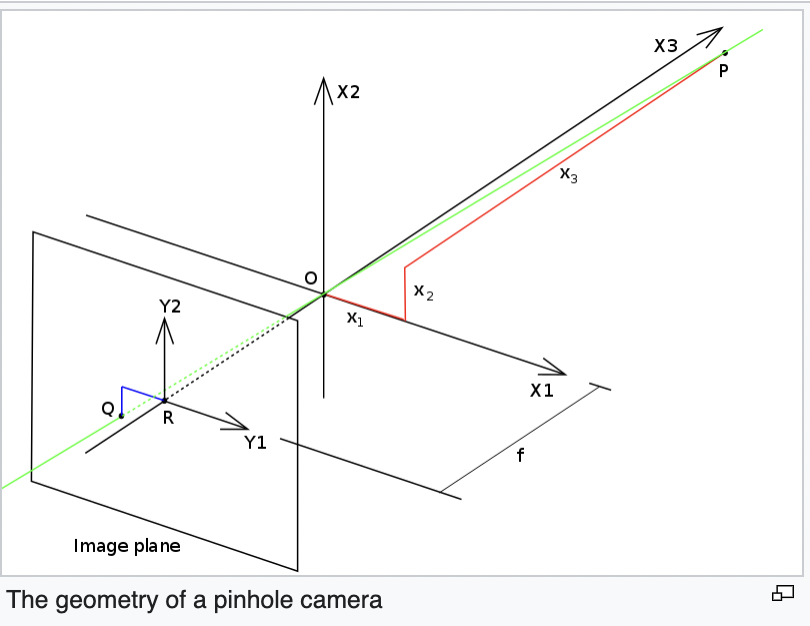



####Step 3:Solution

I assigned coordinates of $x_p,y_p,z_p$ to the required point and then expressed the equation 

$\frac{pixel_{vertical}}{pixel_{horizontal}}$ = $\frac{f}{Distance_{perpendicular}} * \binom{Distance_{parallelHorizontal}}{Distance_{parallelVertical}}$ 

in terms of the known values as:

$pixel_{vertical} = d[1] - res[1]/2$

$pixel_{horizontal} = d[0] - res[0]/2$

$Distance_{perpendicular} = (y_p - y_d)cos(\theta) - (x_p-x_d)sin(\theta)$

$Distance_{parallelHorizontal} = (y_p - y_d)sin(\theta) + (x_p-x_d)cos(\theta)$

$Distance_{parallelVertical} = z_p-z_d$

where the subscript d denotes the values associated with the drone position.

Substituting values related to the two given drone positions, we obtain a system of linear equations which can be solved via matrix inverses.

After obtaining the values of $x_p and y_p$ in the world frame, $z_p$ can be calculated by substituing their values in the above equation.


####Step 4: Validation:

#####Sanity Check:

To carry out the sanity check, I used the given pixel coodinates of the point from the two positions, the positions of the drone and their respective orientations to verify if the solution is feasible.

This task was performed by creating lines using the camera positions and the given orientations to verify if the solution point was present on one side of the drone (left or right) it was also present on the corresponding half of the image plane as well. Similarly I also verified if the solution point was below the drone that it was also present on the bottom half of the image plane and similarly for if it was above the drone and corresponding top half of the image plane.

Total Time: about 6 hours including analysis, research, coding and write up.

Sources:

1) https://en.wikipedia.org/wiki/Pinhole_camera_model


Solution:
X: between 5.75-6

Y: between 3.75-4

Z: between .5-.75